# Testing phase retrieval algos
* use 3D Shepp-Logan phantom
* calculate autocorrelation sinogram
* implement PRT from 2017 Ancora paper

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import phantom_3d as ph
from scipy.fft import fft, fftshift, ifft, fft2, ifft2
PH_SIZE = 64

In [2]:
# embed the cube in cube of zeros for radon transform to work
shepp = np.zeros((2*PH_SIZE, PH_SIZE, 2*PH_SIZE))
shepp_target = ph.phantom3d()
shepp[PH_SIZE//2:-PH_SIZE//2, 
      :,
      PH_SIZE//2:-PH_SIZE//2] = shepp_target
shepp.shape

(128, 64, 128)

In [3]:
## mean amplitude projection
shepp_mean0 = shepp.mean(axis=0)
shepp_mean1 = shepp.mean(axis=1)
shepp_mean2 = shepp.mean(axis=2)

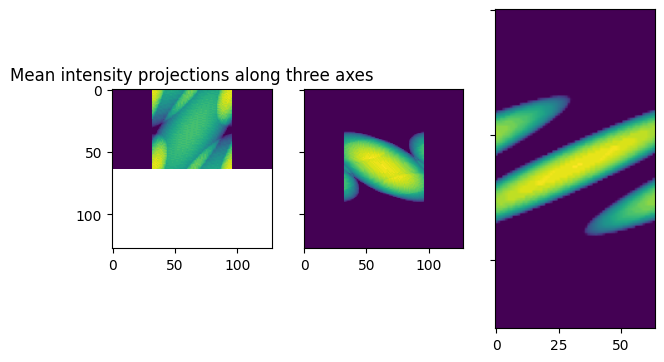

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(7,10), sharey=True)
ax[0].imshow(shepp_mean0)
ax[1].imshow(shepp_mean1)
ax[2].imshow(shepp_mean2)
# plt.colorbar()
ax[0].set_title('Mean intensity projections along three axes')
plt.show()

In [5]:
# plt.imshow(shepp[64,:,:])

### Sinogram
* by performing radon transform

In [6]:
from skimage.transform import radon, rescale

In [7]:
sinogram = radon(shepp[:,32,:])

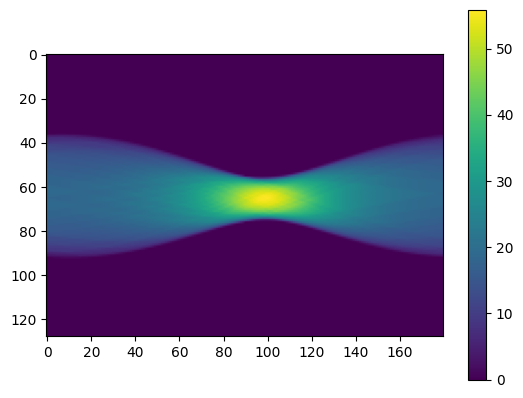

In [8]:
plt.imshow(sinogram)
plt.colorbar()
plt.show()

In [9]:
sino3d = np.zeros((PH_SIZE, 2*PH_SIZE, 180))
for i in range(PH_SIZE):
    sino3d[i,:,:] = radon(shepp[:, i, :])

## Autocorrelation sinogram

In [170]:
# https://stackoverflow.com/questions/4503325/autocorrelation-of-a-multidimensional-array-in-numpy
def xcorr(x):
    """
    FFT based autocorrelation function,
    which is faster than numpy.correlate
    """
    length = len(x[0])
    # x is supposed to be an array of sequences, of shape
    # (totalelements, length)
#     fftx = fft(x, n=(length*2-1), axis=1)
    #version which does not extend the axis
    fftx = fft(x, n=length, axis=1)
    ret = ifft(fftx * np.conjugate(fftx), axis=1)
    ret = fftshift(ret, axes=1)
    return abs(ret)

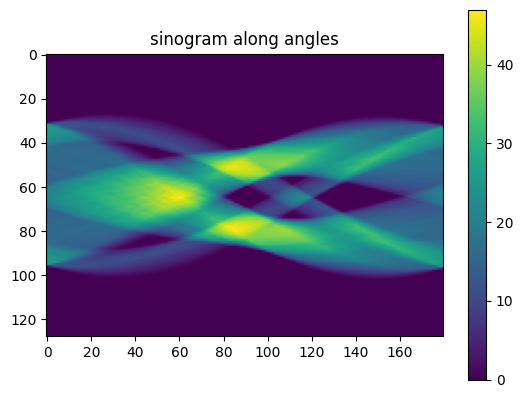

In [171]:
plt.imshow(sino3d[0,:,:])
plt.colorbar()
plt.title('sinogram along angles')
plt.savefig('out1.png')
plt.show()

### test autocorr

In [172]:
Aslice = xcorr(sino3d[0,:,:])

In [173]:
print(len(sino3d), len(sino3d[0]))

64 128


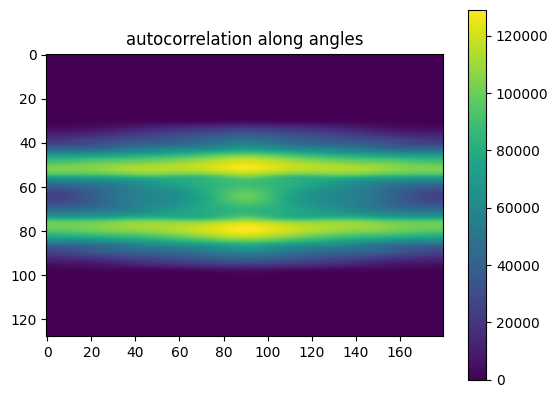

In [175]:
plt.imshow(Aslice)
plt.colorbar()
plt.title('autocorrelation along angles')
plt.show()

In [177]:
# Asino = np.zeros((len(sino3d),
#                    len(sino3d[0]),
#                    len(sino3d[0,0])),dtype=np.complex128)
Asino = np.zeros((len(sino3d),
                   len(sino3d[0]),
                   len(sino3d[0,0])))

In [178]:
for i in range(len(sino3d)):
    Asino[i,:,:] =  xcorr(sino3d[i,:,:])

## iPRT algo
1. g0 is the measured sino3d slice (with random added phase)
2. Then FT and replace amplitude by autocorrelation ampl
3. iFT, apply the positivity conditions in $\Gamma$ region.

In [179]:
# recovery error function (REF)
BETA = 0.1
def ref(curr, meas):
    return ((abs(curr) - abs(meas))**2).sum()

# exponential form
def z2exp(x):
    mod = abs(x)
    phase = np.angle(x)
    return (mod, phase)

def exp2z(x):
    return x[0]*np.exp(1j*x[1])

In [180]:
# random guess
# autocorr is a_sino
# measured is sino3d[0,:,:] slice
g0 = Aslice * np.random.uniform(
                low=-np.pi,
                high=np.pi,
                size=Aslice.shape)

(-9.701276818911236e-12+7.437645561165281e-12j)


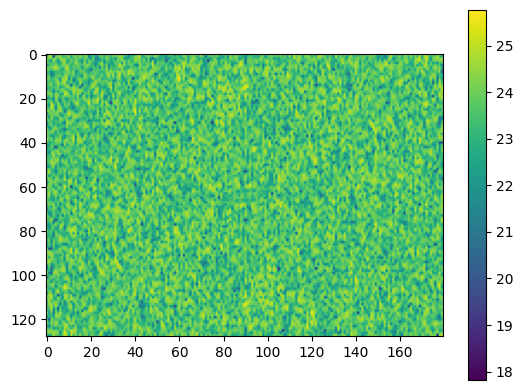

In [181]:
# FT estimate
est_ft = fft2(g0)
print(est_ft.mean())
plt.imshow(abs(np.log2(est_ft)))
plt.colorbar()
plt.show()

In [182]:
est_ft_exp = z2exp(est_ft)

In [183]:
# swap the modulus of estimate with the measured one
est_ft_swap = exp2z( (abs(a), est_ft_exp[1]))

In [184]:
new_est = ifft2(est_ft_swap)

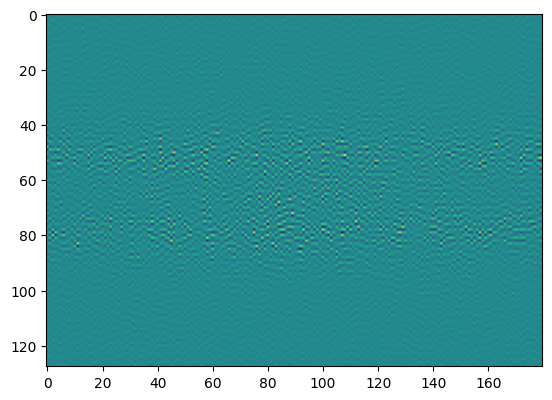

In [185]:
plt.imshow(new_est.real)

In [186]:
## check where the array is not real and positive
len(np.where(new_est.imag==0))

2

In [187]:
g_new = new_est
idx = PH_SIZE//2
g_new[idx:-idx,:] = g0[idx:-idx, :]-BETA * g_new[idx:-idx, :]

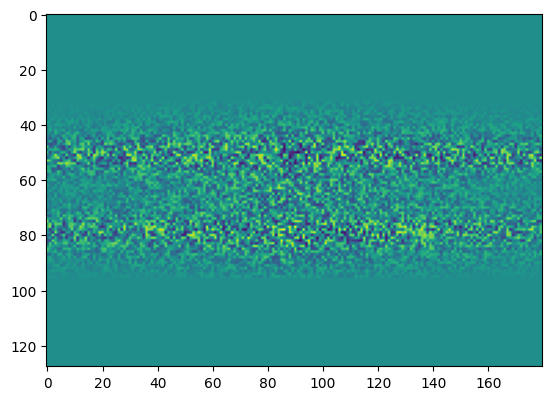

In [188]:
plt.imshow(g_new.real)

In [332]:
def descent01(iguess, autocorr, meas, n_iter=100, beta=0.5, pad=32):
    '''
    first trial where I am replacing only the amplitude after FT
    '''
    g0 = iguess
    err = []
    for i in range(n_iter):
        est_ft = fft2(g0)
        est_ft_exp = z2exp(est_ft)
        est_ft_swap = exp2z( (autocorr, est_ft_exp[1]))
        new_est = ifft2(est_ft_swap)
    
        g_new = new_est
        g_new[pad:-pad,:] = g0[pad:-pad, :]-beta * g_new[pad:-pad, :]
        err
        err.append(ref(meas, g_new))
        g0 = g_new
    return g0, err

def descent01_er(iguess, autocorr, meas, n_iter=100, beta=0.5, pad=32):
    '''
    first trial where I am replacing only the amplitude after FT
    '''
    g0 = iguess
    err = []
    for i in range(n_iter):
        est_ft = fft2(g0)
        est_ft_exp = z2exp(est_ft)
        est_ft_swap = exp2z( (autocorr, est_ft_exp[1]))
        new_est = ifft2(est_ft_swap)
    
        g_new = new_est
        g_new[pad:-pad,:] = g0[pad:-pad, :]-beta * g_new[pad:-pad, :]
        err.append(ref(meas, g_new))
        g0 = g_new

    # error reducing iterations
    for i in range(200):
        est_ft = fft2(g0)
        est_ft_exp = z2exp(est_ft)
        est_ft_swap = exp2z( (autocorr, est_ft_exp[1]))
        new_est = ifft2(est_ft_swap)
        
        g_new = new_est
        g_new[pad:-pad,:] = 0
        err.append(ref(meas, g_new))
        g0 = g_new
        
    return g0, err


def descent02(iguess, autocorr, meas, n_iter=100, beta=0.5, pad=32):
    '''
    puts autocorrelation ampl in FT space
    but correction is done pixel by pixel
    '''
    g0 = iguess
    err_fspace = []
    err_rspace = []
    for i in range(n_iter):
        est_ft = fft2(g0)
        err_fspace.append(ref(est_ft, autocorr))
        est_ft_exp = z2exp(est_ft)
        est_ft_swap = exp2z(
                        (autocorr, est_ft_exp[1])
                        )
        new_est = ifft2(est_ft_swap)
    
#         g_new = new_est
#         g_new[pad:-pad,:] = g0[pad:-pad, :] - beta * g_new[pad:-pad, :]
        
        
        # change here, putting meas amplitude again
        new_est_exp = z2exp(new_est)
        new_est_swap = exp2z(
                        (meas, new_est_exp[1])
                        )
        err_rspace.append(ref(new_est_swap, meas))
        g0 = new_est_swap
    return g0, err_rspace, err_fspace

def GS(source, target, n_iter=100):
    '''
    source is measurement
    target is autocorrelation
    '''
    g0 = ifft2(target)
    err = []
    for i in range(n_iter):
        img_rspace = source * g0/abs(g0)
        img_ft = fft2(img_rspace)
        
        img_kspace = target * img_ft/abs(img_ft)
        g0 = ifft2(img_kspace)
        
        err.append(ref(g0, source))
    return g0, err

def GS_hio(source, target, n_iter, beta):
    g0 = ifft2(target)
    err = []
    for i in range(n_iter):
        img_rspace = source * g0/abs(g0)
        img_ft = fft2(img_rspace)
        
        img_kspace = target * img_ft/abs(img_ft)
        rspace_est = ifft2(img_kspace).real
        
        # error reduction
        gamma = rspace_est > 0
        g0 = rspace_est*gamma - (~gamma*(g0 - (beta*rspace_est)))
#         for j in range(len(g0[:, 0])):
#             for k in range(len(g0[0, :])):
#                 if rspace_est[j, k] < 0:
#                     g0[j, k] -= beta*rspace_est[j, k]
#                 else:
#                     g0[j, k] = rspace_est[j, k]
        
        err.append(ref(g0, source))
    return g0, err

In [333]:
meas = sino3d[0, :, :]
Aslice = xcorr(meas)
g0 = Aslice * np.random.uniform(
                low=-np.pi,
                high=np.pi,
                size=Aslice.shape)

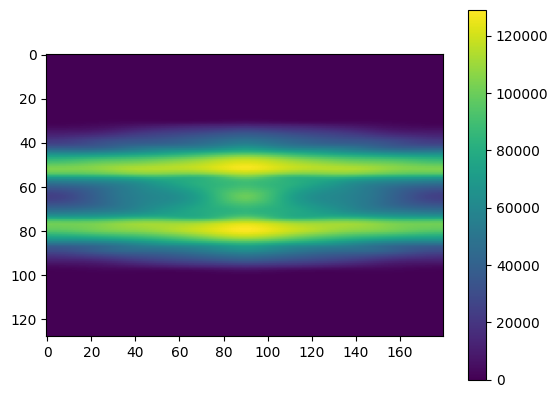

In [334]:
plt.imshow(Aslice)
plt.colorbar()
plt.show()

In [353]:
# fit, err = descent01(g0, Aslice, meas, n_iter=1000, beta=1)
# fit2, err2 = descent01_er(g0, Aslice, meas, n_iter=1000, beta=1)
fit2, errr = GS_hio(meas, Aslice, n_iter=300, beta=0.1)

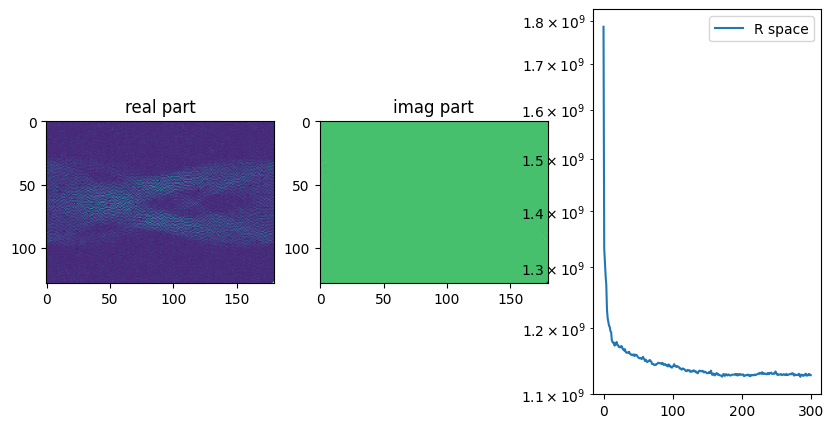

In [354]:
fig, ax = plt.subplots(1,3, figsize=(10,5))
# ax[0].imshow(abs(Aslice))
ax[0].imshow(fit2.real)
ax[1].imshow(fit2.imag)
# ax[2].plot(err, label='v01')
ax[2].plot(errr, label='R space')
# ax[2].plot(errf, label='f space')
ax[2].legend()
ax[2].set_yscale('log')
ax[0].set_title('real part')
ax[1].set_title('imag part')
plt.savefig('out.png')
plt.show()

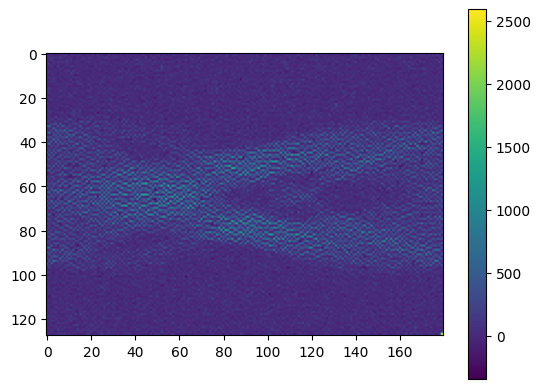

In [355]:
plt.imshow(fit2.real)
plt.colorbar()

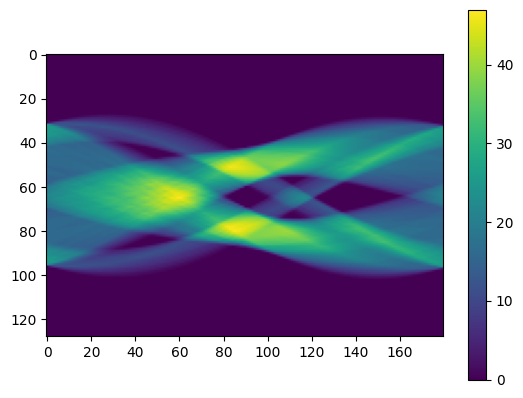

1127996769.1951969


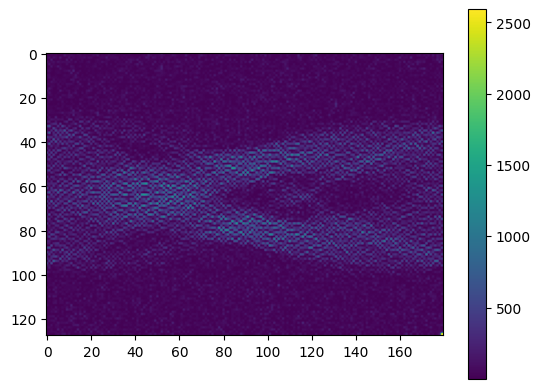

In [356]:
plt.imshow(meas)
plt.colorbar()
plt.show()
plt.imshow(abs(fit2))
plt.colorbar()
print(((meas-abs(fit2))**2).sum())

## maybe works
# Implement the whole dataset but now for cuts at angles

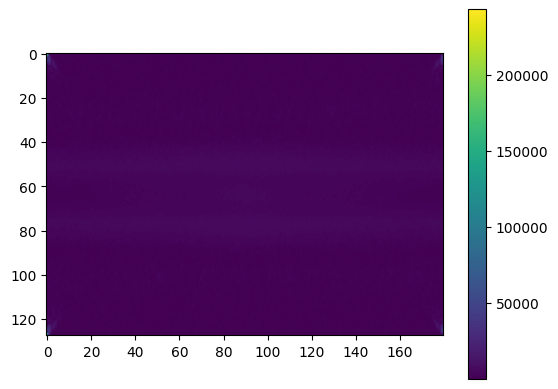

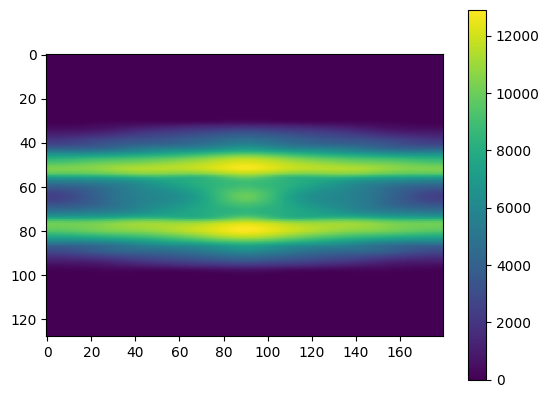

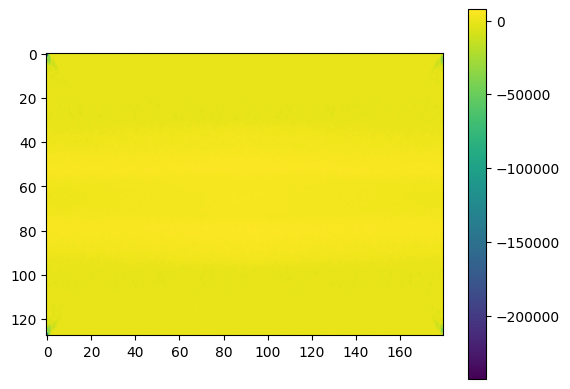

-243006.0590287624


In [350]:
# fig, axs = plt.subplots(2,1)
plt.imshow(abs(fft2(fit2)))
plt.colorbar()
plt.show()

plt.imshow(Aslice/10)
plt.colorbar()
plt.show()

plt.imshow(Aslice/10-abs(fft2(fit2)))
plt.colorbar()
plt.show()

print(np.amin(Aslice/10-abs(fft2(fit2))))

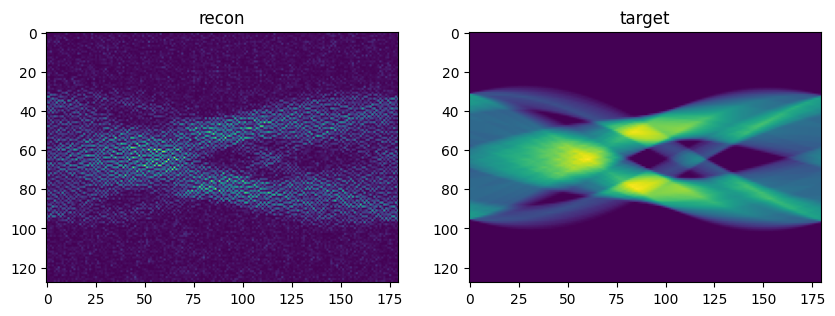

In [351]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(abs(fit2))
ax[0].set_title('recon')
ax[1].imshow(meas)
ax[1].set_title('target')
plt.savefig('sinogram.png')
plt.show()

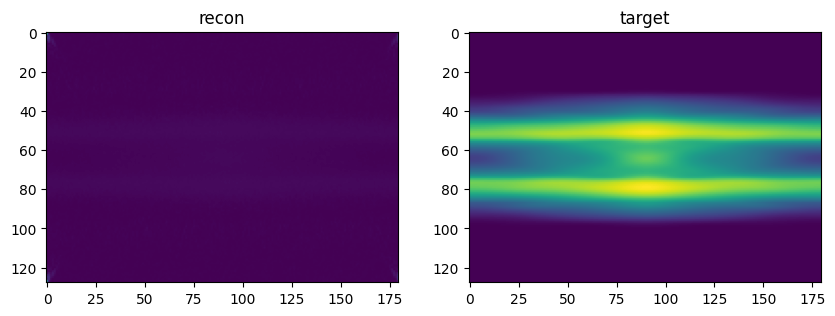

In [352]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(abs(fft2(fit2)))
ax[0].set_title('recon')
ax[1].imshow(Aslice)
ax[1].set_title('target')
plt.savefig('autocorr.png')
plt.show()

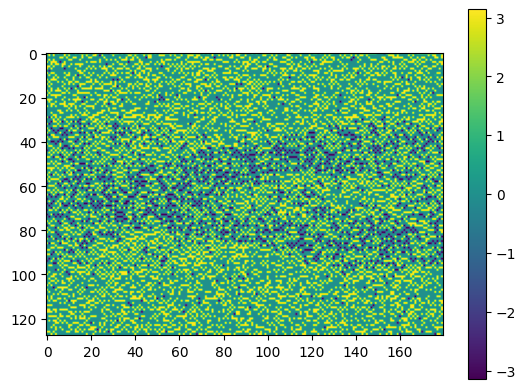

In [344]:
plt.imshow(np.angle(fit2))
plt.colorbar()
plt.show()

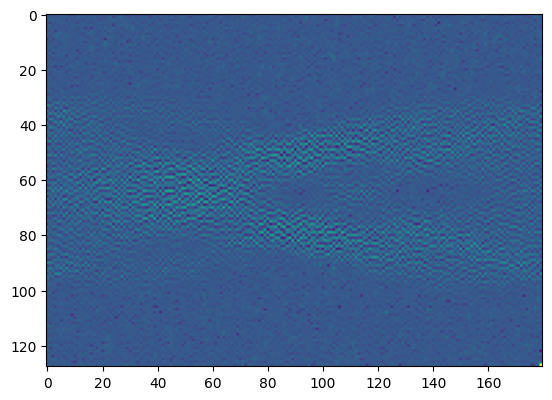

In [345]:
plt.imshow(fit2.real)
plt.show()